# Reproducing The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks (ICLR 2019)

### This script reproduces the core experiments of the Lottery Ticket Hypothesis:
- Training LeNet on MNIST
- Iterative magnitude-based pruning
- Resetting surviving weights to initial values
- Early stopping on validation set
- Final plots include accuracy vs iteration and accuracy vs sparsity

In [ ]:
# Used library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and Utility
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def setup_data(batch_size=128):
    transform = transforms.ToTensor()
    full_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)
    train_len = int(0.9 * len(full_train))
    val_len = len(full_train) - train_len
    train_data, val_data = random_split(full_train, [train_len, val_len])
    return (
        DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True),
        DataLoader(val_data, batch_size=1000, pin_memory=True),
        DataLoader(test_set, batch_size=1000, pin_memory=True)
    )

In [2]:
# AMP training step
def train_amp(model, loader, optimizer, criterion, scaler, device):
    model.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with autocast():
            output = model(data)
            loss = criterion(output, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

# Evaluation step (shared by val/test)
def evaluate(model, loader, criterion, device):
    model.eval()
    correct, total_loss = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = 100. * correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

# Pruning function (iterative pruning support)
def prune_by_percentile(model, percent, current_mask=None):
    all_weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            masked = param if current_mask is None else param * current_mask.get(name, 1)
            all_weights += list(masked.abs().flatten().cpu().detach().numpy())
    threshold = np.percentile(all_weights, percent)
    new_mask = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            masked = param if current_mask is None else param * current_mask.get(name, 1)
            new_mask[name] = (masked.abs() > threshold).float()
    return new_mask

# Reset with mask
def apply_mask_and_reset(model, initial_weights, mask_dict):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in mask_dict:
                param.copy_(initial_weights[name] * mask_dict[name])


In [ ]:
# Experiment based on paper (5x trials, 5x Iteration per trials)
def run_full_experiment(device, prune_percent=20, max_iterations=5, early_stop_patience=3, num_trials=5):
    criterion = nn.CrossEntropyLoss()
    all_trials_results = []

    train_loader, val_loader, test_loader = setup_data()

    for trial in range(num_trials):
        print(f"\n[Trial {trial + 1}/{num_trials}] Starting new trial...")
        model = LeNet().to(device)
        scaler = GradScaler()
        initial_weights = {k: v.clone() for k, v in model.state_dict().items()}
        current_mask = {k: torch.ones_like(v) for k, v in initial_weights.items() if 'weight' in k}
        trial_accs = []

        for iteration in range(max_iterations):
            print(f"\n Iteration {iteration + 1}/{max_iterations} (Pruning {prune_percent}% of remaining weights)")
            model.load_state_dict(initial_weights)
            apply_mask_and_reset(model, initial_weights, current_mask)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

            best_val_acc = 0
            patience = 0
            last_test_acc = 0

            for epoch in range(1, 51):
                train_amp(model, train_loader, optimizer, criterion, scaler, device)
                _, val_acc = evaluate(model, val_loader, criterion, device)
                _, test_acc = evaluate(model, test_loader, criterion, device)

                print(f"     [Epoch {epoch:2d}] Val Acc = {val_acc:.2f}% | Test Acc = {test_acc:.2f}%")

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience = 0
                else:
                    patience += 1

                if patience >= early_stop_patience:
                    print(f"Early stopping triggered after {epoch} epochs (patience={early_stop_patience})")
                    break

                last_test_acc = test_acc

            print(f"Iteration {iteration + 1} finished with Test Accuracy = {last_test_acc:.2f}%\n")
            trial_accs.append(last_test_acc)
            current_mask = prune_by_percentile(model, prune_percent, current_mask)

        print(f"[Trial {trial + 1}] Completed with final accuracies: {trial_accs}\n")
        all_trials_results.append(trial_accs)

    return np.array(all_trials_results)

In [ ]:
# Accuracy vs Prunning 
def plot_accuracy_vs_iteration(all_trials_results):
    mean_accs = np.mean(all_trials_results, axis=0)
    std_accs = np.std(all_trials_results, axis=0)
    iterations = list(range(1, len(mean_accs) + 1))

    plt.figure(figsize=(7, 4.5))
    plt.errorbar(iterations, mean_accs, yerr=std_accs, fmt='o-', capsize=5, elinewidth=1.8, color='navy', label='Accuracy ± Std')
    plt.xticks(iterations, [f'Iter {i}' for i in iterations])
    plt.xlabel('Pruning Iteration', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Test Accuracy Across Iterative Pruning', fontsize=13)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [ ]:
# Accuracy vs Sparsity
def plot_accuracy_vs_sparsity(all_trials_results, prune_percent):
    remaining_weights = [100]
    acc_means = [np.mean(all_trials_results[:, 0])]
    acc_stds = [np.std(all_trials_results[:, 0])]

    current_remain = 100
    for i in range(1, all_trials_results.shape[1]):
        current_remain *= (1 - prune_percent / 100)
        remaining_weights.append(round(current_remain, 1))
        acc_means.append(np.mean(all_trials_results[:, i]))
        acc_stds.append(np.std(all_trials_results[:, i]))

    plt.figure(figsize=(7, 4.5))
    plt.errorbar(remaining_weights, acc_means, yerr=acc_stds, fmt='o-', capsize=5, elinewidth=1.8, color='green', label='Accuracy ± Std')
    plt.xlabel('Weights Remaining (%)', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Test Accuracy vs Sparsity', fontsize=13)
    plt.xticks(remaining_weights)
    plt.gca().invert_xaxis()
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


100.0%
100.0%
100.0%
100.0%



🔁 Trial 1


C:\Users\jeezx\AppData\Local\Temp\ipykernel_16728\1662141166.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\jeezx\AppData\Local\Temp\ipykernel_16728\3139731351.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


   Iteration 1/5
   Iteration 2/5
   Iteration 3/5
   Iteration 4/5
   Iteration 5/5

🔁 Trial 2
   Iteration 1/5
   Iteration 2/5
   Iteration 3/5
   Iteration 4/5
   Iteration 5/5

🔁 Trial 3
   Iteration 1/5
   Iteration 2/5
   Iteration 3/5
   Iteration 4/5
   Iteration 5/5

🔁 Trial 4
   Iteration 1/5
   Iteration 2/5
   Iteration 3/5
   Iteration 4/5
   Iteration 5/5

🔁 Trial 5
   Iteration 1/5
   Iteration 2/5
   Iteration 3/5
   Iteration 4/5
   Iteration 5/5


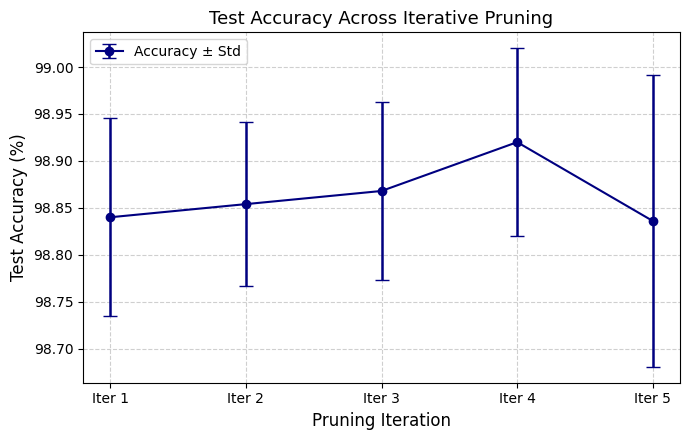

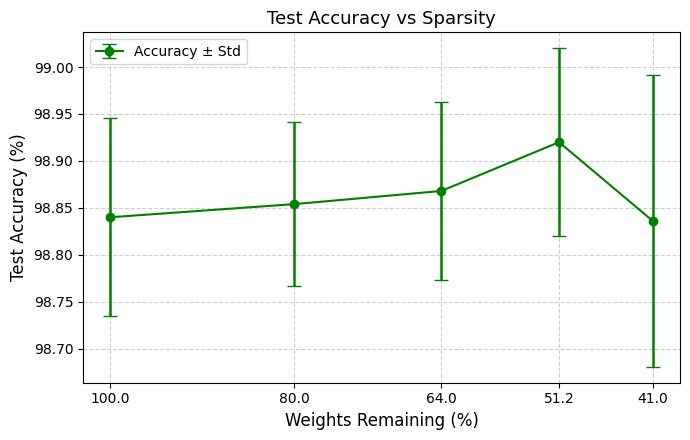

In [ ]:
# Run Full Experiment
results = run_full_experiment(device, prune_percent=20, max_iterations=5, early_stop_patience=3, num_trials=5)

# Visualiation
plot_accuracy_vs_iteration(results)
plot_accuracy_vs_sparsity(results, prune_percent=20)